In [2]:
import os
import json
import pytz
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

ROOT_DIR = os.path.dirname(os.path.dirname(os.getcwd()))
USERS_TWEETS_DIR = os.path.join(ROOT_DIR, 'output', 'tweets', '2022-02-06')

MIN_DATE = dt.datetime(2021, 8, 1, 0, 0, 0, 0, pytz.UTC)
MAX_DATE = dt.datetime(2022, 1, 31, 0, 0, 0, 0, pytz.UTC)

keywords = {
    'covid': [
      'alemka', 'markotic', 'markotić', 'beros', 'beroš', 'capak', 'hzjz',
      
      'antigensk', 'antimaskeri', 'antivakseri',
      
      'cijep', 'cijepiv', 'cijeplj', 'cijepljen', 'cjep', 'cjepiv', 'cjepljen',
      
      'booster doza', 'prva doza', 'druga doza', 'treca doza', 'treća doza',
      'astra zeneca', 'biontech', 'curevac', 'inovio', 'janssen', 'johnson', 
      'novavax', 'moderna', 'pfizer', 'vaxart',
      
      'sojevi koronavirusa', 'brazilski', 'britanski', 'ceski soj', 'delta', 
      'indijski', 'juznoafricki', 'južnoafrički', 'lambda', 
      'njujorski',  'njujorški', 'omikorn', 'omikron', 'novi soj', 'češki soj'
      
      'coron', 'corona', 'covid', 'covid-19', 'covid 19', 'koron', 'korona', 'kovid', 
      'ncov', 'mutira', 'mutaci', 'n95', 'sars-cov-2', 'sarscov2', 'sputnik',
      
      'inkubacij', 'ljekov', 'obolje', 'novozaražen', 'nuspoj', 'patoge', 'regeneron', 
      'medicin', 'infekc', 'dezinf', 'bolnic', 'dijagnost', 'doktor', 'epidem', 
      'respir', 'respirator', 'simpto', 'rt pcr', 'terapij', 'viro', 'virus',
      
      'slusaj struku', 'slušaj struku', 'propusnic', 'ostani doma', 'ostanimo doma', 'zaraž', 
      'festivala slobod',  'pcr', 'samoizola','samoizolacij', 'testira', 'zaraz',
      'distanc', 'izolac', 'karant', 'lockd', 'mask', 'festival slobod', 
      'ostanimo odgovorni', 'pandem', 'pandemij', 'stozer', 'stožer',
    ]
}


if not os.path.exists('2021_08-2022_02-tweets.csv'):
    data = []
    for fn in os.listdir(USERS_TWEETS_DIR):
        with open(os.path.join(USERS_TWEETS_DIR, fn), 'r', encoding='utf-8') as f:
            content = json.load(f)
        for item in content:
            data.append({
                'id': item.get('id'),
                'user_id': int(fn.replace('.json', '')),
                'full_text': item.get('full_text'),
                'created_at': item.get('created_at')
            })

    df = pd.DataFrame(data)
    df['created_at'] = pd.to_datetime(df['created_at'], format='%a %b %d %H:%M:%S %z %Y') # 30s
    df['week']  = df['created_at'].dt.strftime('%Y-%W')
    df['month'] = df['created_at'].dt.strftime('%Y-%m')
else:
    df = pd.read_csv('2021_08-2022_02-tweets.csv')
    df['created_at'] = pd.to_datetime(df['created_at'], format='%Y-%m-%d %H:%M:%S%z') # 30s

df.info()

In [3]:
df = df[
    (df['created_at'] > MIN_DATE)
    & (df['created_at'] < MAX_DATE)
]

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1796136 entries, 0 to 1796135
Data columns (total 7 columns):
 #   Column      Dtype              
---  ------      -----              
 0   id          int64              
 1   user_id     int64              
 2   full_text   object             
 3   created_at  datetime64[ns, UTC]
 4   week        object             
 5   month       object             
 6   is_covid    bool               
dtypes: bool(1), datetime64[ns, UTC](1), int64(2), object(3)
memory usage: 97.6+ MB


In [4]:

df['is_covid'] = df['full_text'].transform(lambda x: any(
        isinstance(x, str) and (tag in x.lower()
        or tag.replace(' ', '') in x.replace(' ', ''))
    for tag in keywords['covid']))

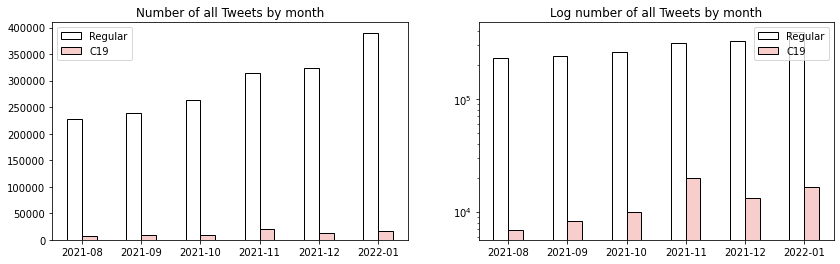

In [167]:
fig, ax = plt.subplots(ncols=2, figsize=(14, 4))


df.groupby(['month', 'is_covid']).size().unstack('is_covid') \
    .plot.bar(
        title="Number of all Tweets by month", 
        rot=0,
        ax=ax[0],
        color=['#ffffff', '#f8cecc'],
        edgecolor='black'
    )
ax[0].legend(['Regular', 'C19'])
ax[0].set_xlabel(None)

df.groupby(['month', 'is_covid']).size().unstack('is_covid') \
    .plot.bar(
        title="Log number of all Tweets by month", 
        rot=0,
        ax=ax[1],
        color=['#ffffff', '#f8cecc'],
        edgecolor='black',
        logy=True
    )
ax[1].legend(['Regular', 'C19'])
ax[1].set_xlabel(None)

plt.show()

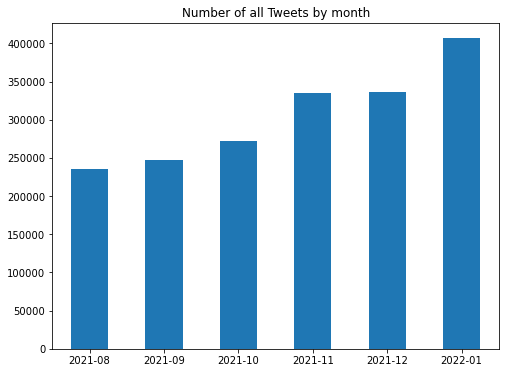

In [168]:
df.groupby('month').size().plot.bar(title="Number of all Tweets by month", rot=0, figsize=(8, 6))
plt.xlabel(None)
plt.show()

In [169]:
print("All Tweets:", len(df))
df.groupby('is_covid').size()

All Tweets: 1834194


is_covid
False    1759282
True       74912
dtype: int64

In [8]:
users_df = df.groupby('user_id').size().reset_index(name='total_tweets').set_index('user_id')
users_df['covid_tweets'] = df[df['is_covid'] == True].groupby('user_id').size()
users_df['is_covid'] = users_df['covid_tweets'].transform(lambda x: x > 0)
users_df['covid_tweets'] = users_df['covid_tweets'].fillna(0)
users_df['covid_pct'] = users_df['covid_tweets'] / users_df['total_tweets']

print("[all] Unique # of users:", len(users_df))
print("[all] Unique # of users with at least 5 Tweets:", len(users_df[users_df['total_tweets'] > 5]))

print("[at least 1 covid tweet] Unique # of users:", len(users_df[users_df['is_covid'] == True]))
print("[at least 1 covid tweet] Unique # of users with at least 5 Tweets:", len(users_df[(users_df['is_covid'] == True) & (users_df['total_tweets'] > 5)]))

users_df.sort_values(by='covid_pct', ascending=False)#.to_csv('user_tweets.csv')

[all] Unique # of users: 8809
[all] Unique # of users with at least 5 Tweets: 6110
[at least 1 covid tweet] Unique # of users: 3653
[at least 1 covid tweet] Unique # of users with at least 5 Tweets: 3469


,total_tweets,covid_tweets,is_covid,covid_pct
user_id,,,,
1719512017,1,1.0,True,1.0
3119167223,1,1.0,True,1.0
18602917,1,1.0,True,1.0
39341939,1,1.0,True,1.0
72262652,1,1.0,True,1.0
...,...,...,...,...
631164890,19,0.0,False,0.0
630200655,1,0.0,False,0.0
630027269,5,0.0,False,0.0


<AxesSubplot:ylabel='Frequency'>

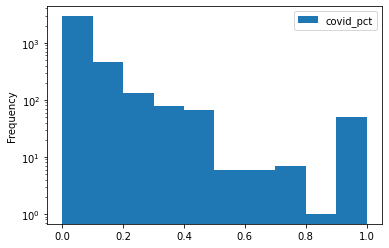

In [172]:
users_df[users_df['is_covid'] == True][['covid_pct']].plot.hist(logy=True)

In [9]:
users_friends = {}
for fn in os.listdir(os.path.join(ROOT_DIR, 'output', 'users', 'ids', '2022-02-05')):
    user_id = fn.replace('.json', '')
    if int(user_id) in users_df.index:
        fpath = os.path.join(ROOT_DIR, 'output', 'users', 'ids', '2022-02-05', fn)
        with open(fpath, 'r') as f:
            user = json.load(f).get(user_id)
            users_friends.update({user_id: {}})
            users_friends[user_id]['friends'] = list(filter(lambda x: x in users_df.index, user['friends']))
            users_friends[user_id]['followers'] = list(filter(lambda x: x in users_df.index, user['followers']))
            users_friends[user_id]['friends_count'] = len(users_friends[user_id]['friends'])
            users_friends[user_id]['followers_count'] = len(users_friends[user_id]['followers'])

with open('2022-02-07_user-friends.json', 'w') as f:
    json.dump(users_friends, f, indent=2)

In [7]:
df.set_index('id').to_csv('2022-02-07_tweets.csv', encoding='utf-8')
users_df.to_csv('2022-02-07_user_tweets.csv', encoding='utf-8')

In [11]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

users_df = pd.read_csv('2022-02-07_tweets.csv')
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1796136 entries, 0 to 1796135
Data columns (total 7 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   id          int64 
 1   user_id     int64 
 2   full_text   object
 3   created_at  object
 4   week        object
 5   month       object
 6   is_covid    bool  
dtypes: bool(1), int64(2), object(4)
memory usage: 83.9+ MB


In [47]:
import numpy as np

udf = users_df.groupby('user_id').agg(
    total_tweets=('user_id', 'size'),
)
udf['covid_tweets'] = users_df[users_df['is_covid']==True].groupby('user_id').size()
udf['covid_tweets'] = udf['covid_tweets'].fillna(0).astype(int)
udf['covid_pct'] = udf['covid_tweets'] / udf['total_tweets']
udf['covid_pct'] = udf['covid_pct'].round(2).replace(np.inf, 0)
udf#.to_csv('nodes_df.csv')

,total_tweets,covid_tweets,covid_pct
user_id,,,
7331,46,3,0.07
11705,4,0,0.00
12667,90,1,0.01
664493,5,0,0.00
680383,2087,40,0.02
...,...,...,...
1482978509219840000,27,1,0.04
1484626648607690761,28,2,0.07
1485244384127983618,12,0,0.00


In [217]:
join_df = users_df.join(
    user_objs_df[user_objs_df['is_croatian'] == True]['screen_name'],
    how='left'
)
join_df = join_df.set_index('screen_name')
join_df

,total_tweets,covid_tweets,is_covid,covid_pct
screen_name,,,,
Neven,46,3.0,True,0.065217
aesqe,4,0.0,False,0.000000
Marko,90,1.0,True,0.011111
doxikus,5,0.0,False,0.000000
BorraBomber,2087,40.0,True,0.019166
...,...,...,...,...
DuStSikac,27,1.0,True,0.037037
MarioGuberina,28,2.0,True,0.071429
FeetCro,12,0.0,False,0.000000


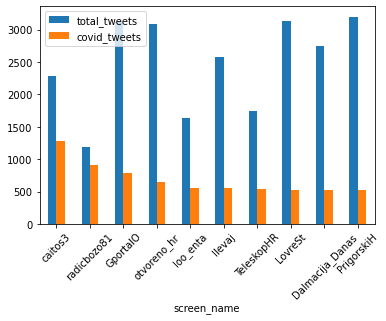

In [218]:
join_df[['total_tweets', 'covid_tweets']] \
    .sort_values(by='covid_tweets', ascending=False) \
    .head(10) \
    .plot.bar(rot=45)

plt.show()

In [3]:
from tqdm import tqdm

with open('2022-02-07_user-friends.json', 'r') as f:
    users_friends_followers = json.load(f)


In [5]:
data = []
for user_id, user in users_friends_followers.items():
    for follower in user['followers']:
        data.append({
            'source': follower,
            'target': int(user_id)
        })

In [7]:
edges_df = pd.DataFrame(data)
edges_df = edges_df[edges_df['target'].isin(edges_df['source'].unique())]
edges_df#.to_csv('edges_df.csv', index=False)

,source,target
0,618134904,1000126763379326976
1,2166095642,1000126763379326976
2,1278346131693539331,1000126763379326976
3,1225359432781094914,1000126763379326976
4,848620561760694273,1000126763379326976
...,...,...
305048,67077504,999423708019163136
305049,759086769878994944,999423708019163136
305050,832164998453592064,999423708019163136
305051,98914851,999423708019163136


In [8]:
edges = pd.read_csv('edges_df.csv')
edges.source.value_counts()

3049972011             822
4119626644             795
2743355546             784
210870282              769
2183851111             740
                      ... 
2587140219               1
473236275                1
1610355853               1
187673891                1
1031719815642337280      1
Name: source, Length: 8118, dtype: int64

In [55]:
users_df = users_df.dropna()
users_df['neighbours_count'] = edges.groupby('source').size()
users_df = users_df[['total_tweets', 'covid_tweets', 'is_covid', 'covid_pct']]
users_df.to_csv('nodes.csv')

In [20]:
nodes = pd.read_csv('nodes.csv')
nodes = nodes[nodes['total_tweets'] > 5]
edges = pd.read_csv('edges.csv')
#edges = edges[edges['source'].isin(nodes['id'])]
#edges = edges[edges['target'].isin(edges['source'])]
nodes = nodes[(nodes['id'].isin(edges['source'])) | (nodes['id'].isin(edges['target']))]
nodes['covid'] = nodes['is_covid'].transform(lambda x: 1 if x else 0)
nodes['non_covid'] = nodes['is_covid'].transform(lambda x: 0 if x else 1)
nodes[['covid', 'non_covid', 'covid_group']]

,covid,non_covid,covid_group
0,1,0,uvijek
1,1,0,često
2,1,0,često
3,1,0,ponekad
4,1,0,ponekad
...,...,...,...
5430,0,1,vrlo_rijetko
5431,0,1,vrlo_rijetko
5432,0,1,vrlo_rijetko
5433,0,1,vrlo_rijetko


In [16]:
#node_rename_map = {user_id: i+1 for i, user_id in enumerate(nodes.user_id.values)}
#rename_node = lambda x: node_rename_map[x]
#edges['source'] = edges['source'].transform(rename_node)
#edges['target'] = edges['target'].transform(rename_node)
edges[['source', 'target']]#.to_csv('edges.csv', index=False)

,source,target
0,1588,2487
1,1588,5365
2,1588,4110
3,1588,2969
4,1588,4495
...,...,...
214819,3887,1185
214820,3887,2037
214821,3887,52
214822,3887,2799


In [25]:
#nodes['id'] = nodes['user_id'].transform(rename_node)
nodes['covid_group'] = nodes['covid_pct'].transform(lambda x:
    'nikad' if x == 0 else
    'vrlo_rijetko' if x > 0 and x <= 0.15 else
    'rijetko' if x > 0.15 and x <= 0.50 else
    'ponekad' if x > 0.50 and x <= 0.75 else
    'često' if x > 0.75 and x < 0.90 else 'uvijek'
)
nodes[['id', 'total_tweets', 'covid_tweets', 'is_covid', 'covid_pct', 'covid', 'non_covid', 'covid_group']].set_index('id')#.to_csv('nodes.csv')

,source,target,source_id,target_id
0,1000126763379326976,618134904,18,239104
1,1000126763379326976,2166095642,18,111178
2,1000126763379326976,1278346131693539331,18,49598
3,1000126763379326976,1225359432781094914,18,39934
4,1000126763379326976,848620561760694273,18,272642
...,...,...,...,...
302648,999423708019163136,67077504,302652,242272
302649,999423708019163136,759086769878994944,302652,256746
302650,999423708019163136,832164998453592064,302652,269156
302651,999423708019163136,98914851,302652,301382


In [ ]:
nodes['']